In [29]:
import os
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import pydicom
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.patches as patches

import importlib
from torchvision.transforms import functional as F
from typing import Any, Dict, List
import pytorch_lightning as pl
import random
import torch.distributed as dist
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torchmetrics

In [3]:
# Set paths to the data directories
base_path = "/data/kaggledata"
train_images_path = f"{base_path}/train_images"
segmentations_path = f"{base_path}/segmentations"
binary_masks_path = f"{base_path}/working/binary_masks"
train_bbox_path = f"{base_path}/train_bounding_boxes.csv"

# **Split Data Using IDs**

In [4]:
# Patient IDs with segmentations
patient_ids_with_masks = [os.path.splitext(f)[0] for f in os.listdir(binary_masks_path)]
 
# Patient IDs with bounding boxes
df_bbox = pd.read_csv(train_bbox_path)
id_column = df_bbox.columns[0]
patient_ids_with_boxes = df_bbox[id_column].unique().tolist()

# Patient Ids with segmentations AND bounding boxes
patient_ids_with_masks_and_boxes = list(set(patient_ids_with_masks) & set(patient_ids_with_boxes))


# Split patients IDs into sets
train_ids, temp_ids = train_test_split(patient_ids_with_masks_and_boxes, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print(f"Train: {len(train_ids)} patients\nVal: {len(val_ids)} patients\nTest: {len(test_ids)} patients")

Train: 28 patients
Val: 6 patients
Test: 6 patients


# **Generate Data for Model**

In [5]:
def dilate_mask(original_mask):
    # Define a kernel
    kernel_size = 20  # Adjust this for more/less dilation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Perform dilation
    dilated_mask = cv2.dilate(original_mask, kernel, iterations=1)
    return dilated_mask

class BBoxDataset(Dataset):
    def __init__(self, patient_ids, image_dir, mask_dir, df_bbox, target_size=(256, 256)):
        self.patient_ids = patient_ids
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.df_bbox = df_bbox
        self.target_size = target_size
        self.samples = self._preload_sample_indices()  # Preload valid (pid, slice_idx) pairs

    def _preload_sample_indices(self):
        samples = []
        for pid in self.patient_ids:
            mask_path = os.path.join(self.mask_dir, f"{pid}.nii")
            masks = nib.load(mask_path).get_fdata()
            
            # Balance fracture/no fracture images, ignore images with no vertebrae
            fracture_count = 0
            no_fracture_count = 0
            
            for slice_idx in range(masks.shape[0]):
                if (np.any(masks[slice_idx] > 0)):
                    fracture_exists = ((df_bbox['StudyInstanceUID'] == pid) & 
                                       (df_bbox['slice_number'] == (slice_idx + 1))).any()
                    if (fracture_exists):
                        fracture_count += 1
                        samples.append((pid, slice_idx, 1))  # (patient_id, slice_idx, is_fracture)
                    elif (no_fracture_count < fracture_count):
                        no_fracture_count += 1
                        samples.append((pid, slice_idx, 0))  # (patient_id, slice_idx, is_fracture)                            
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pid, slice_idx, is_fracture = self.samples[idx]
        
        # Load DICOM
        dicom_path = os.path.join(self.image_dir, pid, f"{slice_idx+1}.dcm")
        dicom = pydicom.dcmread(dicom_path)
        img = dicom.pixel_array.astype(np.float32)
        original_image_width = img.shape[1]
        original_image_height = img.shape[0]
        img = (img - img.min()) / (img.max() - img.min())
        img = cv2.resize(img, self.target_size)
        
        # Load mask
        mask_path = os.path.join(self.mask_dir, f"{pid}.nii")
        masks = nib.load(mask_path).get_fdata()
        mask = masks[slice_idx].astype(np.float32)
        
        # Dilate mask
        dilated_mask = dilate_mask(mask)
        dilated_mask = cv2.resize(dilated_mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # Mask image for vertebrae, using dilated mask
        masked_image = img * dilated_mask
        
        # Convert to PyTorch tensors and add channel dimension
        masked_image_tensor = torch.from_numpy(masked_image).unsqueeze(0).float()  # [1, H, W]

        bbox = []

        resize_image_width = self.target_size[0]
        resize_image_height = self.target_size[1]

        if (is_fracture):
            target_row = df_bbox[(df_bbox['StudyInstanceUID'] == pid) & 
                            (df_bbox['slice_number'] == (slice_idx+1))]
            bbox_width = target_row.iat[0, 3]
            bbox_height = target_row.iat[0, 4]
            
            # xmin = left corner x-coordinates
            xmin = target_row.iat[0, 1]
            # xmax = right corner x-coordinates
            xmax = xmin + bbox_width
            # ymin = left corner y-coordinates
            ymin = target_row.iat[0, 2]
            # ymax = right corner y-coordinates
            ymax = ymin + bbox_height
        
            # resize the bounding boxes
            xmin_final = (xmin/original_image_width)*resize_image_width
            xmax_final = (xmax/original_image_width)*resize_image_width
            ymin_final = (ymin/original_image_height)*resize_image_height
            ymax_final = (ymax/original_image_height)*resize_image_height
        
            bbox.append([xmin_final, ymin_final, xmax_final, ymax_final])
        else:
            rand_num = random.randint(0, 254)
            
            bbox.append([rand_num, rand_num, rand_num+1, rand_num+1])


        # bounding box to tensor
        bbox_tensor = torch.as_tensor(bbox, dtype=torch.float32)

        # labels to tensor
        label_tensor = torch.as_tensor([is_fracture], dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = bbox_tensor
        target["labels"] = label_tensor
        target['image_id'] = torch.tensor([idx])
        
        return masked_image_tensor, target, idx  # Single sample I think?

# **Create Train Dataloader**

In [6]:
train_dataset = BBoxDataset(
    patient_ids=train_ids,
    image_dir=train_images_path,
    mask_dir=binary_masks_path,
    df_bbox=df_bbox,
    target_size=(256, 256)
)

valid_dataset = BBoxDataset(
    patient_ids=val_ids,
    image_dir=train_images_path,
    mask_dir=binary_masks_path,
    df_bbox=df_bbox,
    target_size=(256, 256)
)

# **Visualize Generated Data**

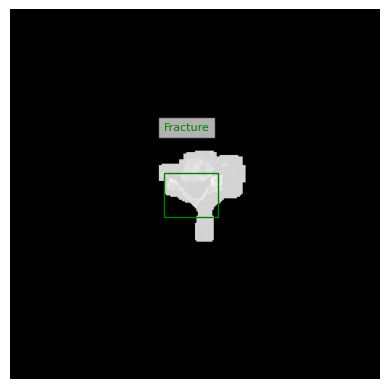

In [75]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4
)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(image, target):
    # Convert image tensor to numpy array
    image = image.squeeze(0).permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
    
    # Create figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    if image.shape[2] == 1:  # Grayscale case
        ax.imshow(image[:, :, 0], cmap='gray')
    else:
        ax.imshow(image)
    
    # Get bounding box coordinates
    box = target['boxes'][0][0].numpy()
    x1, y1, x2, y2 = box  # Get coordinates
    
    # Create a Rectangle patch (only if there's a valid box)
    if any(coord != 0 for coord in box):  # Skip [0,0,0,0] boxes
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=1, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label text
        if target['labels'][0].item() == 1:
            label = "Fracture"
        else: 
            label = "No Fracture"
            
        ax.text(x1, y1-30, label, color='green', fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7))
    
    plt.axis('off')
    plt.show()

image_tensor, target_dict, _ = next(iter(train_dataloader))
visualize_sample(image_tensor, target_dict)

# **Model**

In [8]:
def load_obj(obj_path: str, default_obj_path: str = "") -> Any:
    """Extract an object from a given path.
        Args:
            obj_path: Path to an object to be extracted, including the object name.
            default_obj_path: Default object path.
        Returns:
            Extracted object.
        Raises:
            AttributeError: When the object does not have the given named attribute.
    """
    obj_path_list = obj_path.rsplit(".", 1)
    obj_path = obj_path_list.pop(0) if len(obj_path_list) > 1 else default_obj_path
    obj_name = obj_path_list[0]
    module_obj = importlib.import_module(obj_path)
    if not hasattr(module_obj, obj_name):
        raise AttributeError(
            f"Object `{obj_name}` cannot be loaded from `{obj_path}`."
        )
    return getattr(module_obj, obj_name)

def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT 
model = fasterrcnn_resnet50_fpn(weights=weights)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

head = load_obj('torchvision.models.detection.faster_rcnn.FastRCNNPredictor')

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = head(in_features, 2)


class FractureDetection(pl.LightningModule):

    def __init__(self, model = None):
        super(FractureDetection, self).__init__()
        self.model = model

        self.val_metrics = torchmetrics.detection.MeanAveragePrecision()

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def prepare_data(self):
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_dataset,
                                                   batch_size=1,
                                                   num_workers=4,
                                                   shuffle=True,
                                                   collate_fn=collate_fn)
        return train_loader

    
    def val_dataloader(self):
        valid_loader = torch.utils.data.DataLoader(self.valid_dataset,
                                                   batch_size=1,
                                                   num_workers=4,
                                                   shuffle=False,
                                                   collate_fn=collate_fn)

        return valid_loader

    def configure_optimizers(self):
        # Initialize optimizer with direct parameters
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=0.0001,
            weight_decay=0.001
        )
        
        # Initialize scheduler with direct parameters
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.1,
            patience=5
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "map"
            }
        }

    def training_step(self, batch, batch_idx):
        images, targets, image_ids = batch
        #targets = [{k: v for k, v in t.items()} for t in targets]
        # separate losses
        loss_dict = self.model(images, targets)
        # total loss
        losses = sum(loss for loss in loss_dict.values())

        self.log_dict(
            {f"train_{k}": v for k, v in loss_dict.items()},
            on_step=True,
            on_epoch=True,
            prog_bar=True
        )

        return losses

    def validation_step(self, batch, batch_idx):
        images, targets, image_ids = batch
        #targets = [{k: v for k, v in t.items()} for t in targets]
        # Get predictions
        with torch.no_grad():
            predictions = self.model(images)
        
        # Update metrics
        self.val_metrics.update(predictions, targets)
        
        return {}

    def on_validation_epoch_end(self, outputs=None):
        # Compute metrics
        metrics = self.val_metrics.compute()
        
        # Log metrics
        self.log_dict(
            {
                "map": metrics["map"],
                "map_50": metrics["map_50"],
                "map_75": metrics["map_75"]
            },
            prog_bar=True
        )
        
        # Reset metrics
        self.val_metrics.reset()
        
        return metrics

In [20]:
fracture_model = FractureDetection(model=model)

early_stopping = pl.callbacks.EarlyStopping(
    monitor='map',
    patience=10,
    mode='max',
    check_finite=True, 
    check_on_train_epoch_end=False
)

model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath='/data/kaggledata/working/saved_models/model_2/',
    filename='best-{epoch}-{map:.2f}',
    monitor='map',
    mode='max',
    save_top_k=3,
    auto_insert_metric_name=False,
    save_last=True,
    save_weights_only=False
)

tb_logger = TensorBoardLogger(save_dir='/data/kaggledata/working/saved_models/model_2/logs/')

In [21]:
trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[early_stopping, model_checkpoint],
    devices=1,
    max_epochs=10,
    gradient_clip_val=0.5,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    enable_progress_bar=True,
)
trainer.fit(fracture_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
trainer.save_checkpoint("/data/kaggledata/working/saved_models/model_2/full_model.ckpt")
#torch.save(lit_model.model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [26]:
checkpoint = torch.load("/data/kaggledata/working/saved_models/model_2/full_model.ckpt")
print(checkpoint.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])


# **Testing**

In [82]:
test_dataset = BBoxDataset(
    patient_ids=test_ids,
    image_dir=train_images_path,
    mask_dir=binary_masks_path,
    df_bbox=df_bbox,
    target_size=(256, 256)
)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          num_workers=4,
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [67]:
y_true = []
y_pred = []

fracture_model.eval()

with torch.no_grad():
    for (images,), (targets,), _ in test_loader:
        if images.dim() == 2:
            images = images.unsqueeze(0)  # Add channel if needed

        images_list = [images]  # Wrap in list for torchvision models

        predictions = fracture_model(images_list)
        prediction = predictions[0]

        # Ground truth label
        true_label = targets['labels'][0].item()
        y_true.append(true_label)

        # Predicted label: 1 if any boxes, else 0
        if len(prediction['labels']) > 0:
            pred_label = 1  # Detected object
        else:
            pred_label = 0  # No object detected
        
        y_pred.append(pred_label)

In [69]:
from sklearn.metrics import classification_report

# Print Metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Fracture", "Fracture"]))

Classification Report:

              precision    recall  f1-score   support

 No Fracture       0.53      0.65      0.58       220
    Fracture       0.55      0.43      0.48       220

    accuracy                           0.54       440
   macro avg       0.54      0.54      0.53       440
weighted avg       0.54      0.54      0.53       440



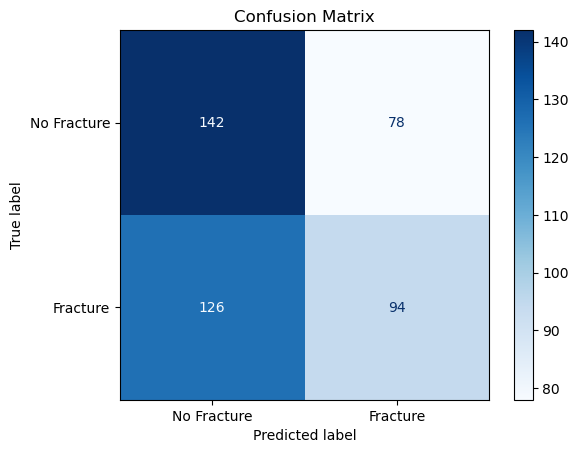

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fracture", "Fracture"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [86]:
import torch

def compute_iou(pred_box, true_box):
    # pred_box and true_box are of the form [x1, y1, x2, y2]
    x1_intersection = max(pred_box[0], true_box[0])
    y1_intersection = max(pred_box[1], true_box[1])
    x2_intersection = min(pred_box[2], true_box[2])
    y2_intersection = min(pred_box[3], true_box[3])

    # Compute area of intersection
    intersection_width = max(0, x2_intersection - x1_intersection)
    intersection_height = max(0, y2_intersection - y1_intersection)
    intersection_area = intersection_width * intersection_height

    # Compute area of both bounding boxes
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    true_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])

    # Compute area of union
    union_area = pred_area + true_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

# Calculate IoUs for all samples:
y_true_boxes = []
y_pred_boxes = []
ious = []

fracture_model.eval()

with torch.no_grad():
    for (images,), (targets,), _ in test_loader:
        # Add a channel dimension to the image if it is missing
        if images.dim() == 3:  # [H, W] -> [1, H, W] (Grayscale case)
            images = images.unsqueeze(0)  # Add batch dimension
        elif images.dim() == 2:  # [H, W] -> [C, H, W] (RGB or grayscale case)
            images = images.unsqueeze(0).unsqueeze(0)  # Add both batch and channel dimension
        elif images.shape[0] == 1:  # If it's grayscale but the channel dimension exists
            images = images.unsqueeze(0)  # Add batch dimension
        
        predictions = fracture_model(images)
        prediction = predictions[0]

        # Check if there are any predicted boxes
        if len(prediction['boxes']) == 0:
            print(f"No boxes predicted for this image. Skipping IoU calculation.")
            continue  # Skip this image if no boxes were predicted
        
        # Ground truth box and predicted box
        true_box = targets['boxes'][0].numpy()  # [x1, y1, x2, y2]
        pred_box = prediction['boxes'][0].cpu().numpy()  # [x1, y1, x2, y2]

        # Compute IoU
        iou = compute_iou(pred_box, true_box)
        ious.append(iou)

        # Optionally, save the boxes to use later for metrics
        y_true_boxes.append(true_box)
        y_pred_boxes.append(pred_box)

# Calculate average IoU
average_iou = sum(ious) / len(ious) if ious else 0
print(f"Average IoU: {average_iou:.4f}")

# Print individual IoUs
for i, iou in enumerate(ious):
    print(f"Sample {i + 1}: IoU = {iou:.4f}")


No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for this image. Skipping IoU calculation.
No boxes predicted for t

{'boxes': tensor([[141.1116,  45.3671, 153.7927,  60.8331]]), 'labels': tensor([1]), 'image_id': tensor([0])}


ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([256, 256])

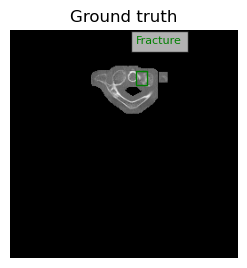

In [83]:
def visualize_inference(image, target):
    # Ground Truth
    # Convert image tensor to numpy array
    image = image.permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]

    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 3, 1)
    
    # Display the image
    if image.shape[2] == 1:  # Grayscale case
        ax.imshow(image[:, :, 0], cmap='gray')
    else:
        ax.imshow(image)

    # Get bounding box coordinates
    box = target['boxes'][0].numpy()
    x1, y1, x2, y2 = box  # Get coordinates
    
    # Create a Rectangle patch (only if there's a valid box)
    if any(coord != 0 for coord in box):  # Skip [0,0,0,0] boxes
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=1, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label text
        if target['labels'][0].item() == 1:
            label = "Fracture"
        else: 
            label = "No Fracture"
            
        ax.text(x1, y1-30, label, color='green', fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7))
    plt.title("Ground truth")   
    plt.axis('off')

    # Inference
    fracture_model.eval()

    predictions = fracture_model(images)
    prediction = predictions[0]

    pred_boxes = prediction['boxes'].data.cpu().numpy()
    pred_boxes = pred_boxes.astype(int)

    ax = plt.subplot(1, 3, 2)
    # Display the image
    if image.shape[2] == 1:  # Grayscale case
        ax.imshow(image[:, :, 0], cmap='gray')
    else:
        ax.imshow(image)

    # Create a Rectangle patch (only if there's a valid box)
    if any(coord != 0 for coord in pred_boxes):  # Skip [0,0,0,0] boxes
        pred_x1, pred_y1, pred_x2, pred_y2 = pred_boxes
        width = pred_x2 - pred_x1
        height = pred_y2 - pred_y1
        rect = patches.Rectangle(
            (pred_x1, pred_y1), width, height,
            linewidth=1, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label text
        if prediction['labels'][0].item() == 1:
            label = "Fracture"
        else: 
            label = "No Fracture"
            
        ax.text(x1, y1-30, label, color='green', fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Prediction")
    plt.axis("off")
    plt.show()

for (image_tensor,), (target_dict,), _ in test_loader:
    visualize_inference(image_tensor, target_dict)
    user_input = input("Press Enter to continue or type 'q' to quit: ")
    if user_input.lower() == 'q':
        break

#(image_tensor,), (target_dict,), _ = next(iter(test_loader))
#visualize_inference(image_tensor, target_dict)